In [1]:
# # Requerimientos de librerías:
# !pip install spacy
# !python -m spacy download es_core_news_md

# !pip install transformers
# !pip install transformers scipy ftfy accelerate

# !git clone https://github.com/JorgeSauri/COMSINT.git 

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
import numpy as np
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
from recomendaciones_comsint import Recomendador

c:\Users\jsaur\anaconda3\envs\ENV1\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Con tamaño embeddings 128
- CNN de max 512 kernels (v4)

In [3]:
version = 4

recomendador128 = Recomendador(fuente='recetario_mexicano_small.csv',
                            nutricion = 'nutricion_mejorado.csv',
                            canasta='canasta_basica.csv')

recomendador128.CargarModelo(emb_size=128, version=version)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Modelo Modelos/Modelo_Nut_FV_DistilBERT_04_EMBED-128_CNN.h5 cargado con éxito.
Modelo Modelos/Modelo_Precios_FV_DistilBERT_04_EMBED-128_CNN.h5 cargado con éxito.


In [5]:
recomendador128.generar_dataset_entrenamiento_nut(df_nutricionales='nutricion_mejorado.csv', 
                                                  min_ingredientes=5, max_ingredientes=11,
                                                  min_unidades=1, max_unidades=5,
                                                  min_kcal=250, max_kcal= 1500,
                                                  numero_recetas=1
                                                  )

# recomendador128.generar_dataset_entrenamiento_precios(df_precios_profeco='lista_precios_profeco_2022.csv', 
#                                                   numero_recetas=1
#                                                   )                                  

Generando 1  recetas aleatorias...



100%|██████████| 1/1 [00:00<00:00, 334.15it/s]


array([['1 mililitros de pan de avena, 4 mililitros de comida de queso  americano  paquete frío, 2 cucharadas de bacalao crudo, 4 cucharaditas de cordero  asado  cocinado  molido, 2 onzas de mantequilla de maní  sin sal  estilo de trozo, 2 tazas de pavo  asado  cocido  carne y piel  pierna  todas las clases, 4 gramos de yogurt  leche entera  llanura  griega, 2 gramos de carne de res  carne picada  ahumada  curada, 1 gramos de coliflor  con sal  drenado  hervido  cocido  congelado, 4 piezas de jugo de tomate y vegetales  bajo sodio, 1 cucharadas de carne de cerdo  cruda  degada y grasa separable  respaldos  frescos',
        '429.68', '30.82', '16.95', '29.09']], dtype='<U612')

* Entrenar información nutricional


ITERACIÓN: 1
min unidades: 1  max unidades: 11
min kcal: 350  max kcal: 1500
Entrenando desde epoch 0
------------------------------------------

Error al cargar archivos NumPy.
datasets/numpy/5000_recetas_random_EMBED-128_DATA_X.npy no existe o está corrupto.
datasets/numpy/5000_recetas_random_EMBED-128_DATA_Y.npy no existe o está corrupto.
Generando 5000  recetas aleatorias...



100%|██████████| 5000/5000 [00:47<00:00, 104.42it/s]


Calculando vector de características de 5000 recetas...


100%|██████████| 5000/5000 [29:04<00:00,  2.87it/s]     


datasets/numpy/9_TEST_EMBED-128_DATA_X.npy cargado con éxito.
datasets/numpy/9_TEST_EMBED-128_DATA_Y.npy cargado con éxito.
datasets/numpy/7_VAL_EMBED-128_DATA_X.npy cargado con éxito.
datasets/numpy/7_VAL_EMBED-128_DATA_Y.npy cargado con éxito.
Model: "ModeloCNNNut_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CapaEntrada (InputLayer)    [(None, 98304)]           0         
                                                                 
 RESHAPING (Reshape)         (None, 128, 768)          0         
                                                                 
 batch_normalization_1 (Batc  (None, 128, 768)         3072      
 hNormalization)                                                 
                                                                 
 CONV_1 (Conv1D)             (None, 124, 512)          1966592   
                                                                 
 P

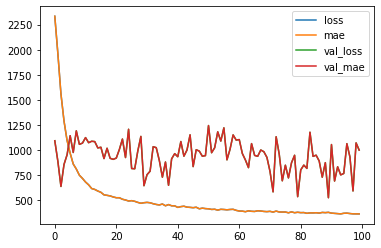

1/1 [==============================] - 0s 267ms/step - loss: 800.3530 - mae: 800.3530
[800.35302734375, 800.35302734375]
1/1 [==============================] - 0s 221ms/step
receta 0 kcal_true: 324.0 kcal_pred: 614.8787  precisión: 52.7 %
receta 0 carbohydrate_true: 76.0 carbohydrate_pred: 67.32431  precisión: 88.6 %
receta 0 protein_true: 8.0 protein_pred: 31.049881  precisión: 25.8 %
receta 0 total_fat_true: 0.0 total_fat_pred: 20.340687  precisión: 0.0 %
---------------------------------------------------------------------------
receta 1 kcal_true: 436.0 kcal_pred: 501.9979  precisión: 86.9 %
receta 1 carbohydrate_true: 96.0 carbohydrate_pred: 55.85957  precisión: 58.2 %
receta 1 protein_true: 8.0 protein_pred: 25.371443  precisión: 31.5 %
receta 1 total_fat_true: 4.0 total_fat_pred: 16.576492  precisión: 24.1 %
---------------------------------------------------------------------------
receta 2 kcal_true: 846.0 kcal_pred: 17684.969  precisión: 4.8 %
receta 2 carbohydrate_true: 72.0

100%|██████████| 5000/5000 [00:54<00:00, 91.71it/s] 


Calculando vector de características de 5000 recetas...


100%|██████████| 5000/5000 [17:36<00:00,  4.73it/s]


datasets/numpy/9_TEST_EMBED-128_DATA_X.npy cargado con éxito.
datasets/numpy/9_TEST_EMBED-128_DATA_Y.npy cargado con éxito.
datasets/numpy/7_VAL_EMBED-128_DATA_X.npy cargado con éxito.
datasets/numpy/7_VAL_EMBED-128_DATA_Y.npy cargado con éxito.
Model: "ModeloCNNNut_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CapaEntrada (InputLayer)    [(None, 98304)]           0         
                                                                 
 RESHAPING (Reshape)         (None, 128, 768)          0         
                                                                 
 batch_normalization_2 (Batc  (None, 128, 768)         3072      
 hNormalization)                                                 
                                                                 
 CONV_1 (Conv1D)             (None, 124, 512)          1966592   
                                                                 
 P

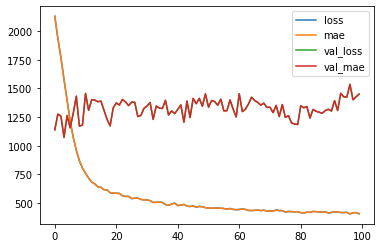

1/1 [==============================] - 0s 292ms/step - loss: 679.5432 - mae: 679.5432
[679.5431518554688, 679.5431518554688]
1/1 [==============================] - 0s 150ms/step
receta 0 kcal_true: 324.0 kcal_pred: 579.54553  precisión: 55.9 %
receta 0 carbohydrate_true: 76.0 carbohydrate_pred: 66.73515  precisión: 87.8 %
receta 0 protein_true: 8.0 protein_pred: 24.825447  precisión: 32.2 %
receta 0 total_fat_true: 0.0 total_fat_pred: 21.21962  precisión: 0.0 %
---------------------------------------------------------------------------
receta 1 kcal_true: 436.0 kcal_pred: 384.5578  precisión: 88.2 %
receta 1 carbohydrate_true: 96.0 carbohydrate_pred: 45.61741  precisión: 47.5 %
receta 1 protein_true: 8.0 protein_pred: 17.506483  precisión: 45.7 %
receta 1 total_fat_true: 4.0 total_fat_pred: 13.841251  precisión: 28.9 %
---------------------------------------------------------------------------
receta 2 kcal_true: 846.0 kcal_pred: 14774.694  precisión: 5.7 %
receta 2 carbohydrate_true: 

100%|██████████| 5000/5000 [00:46<00:00, 108.68it/s]


Calculando vector de características de 5000 recetas...


100%|██████████| 5000/5000 [17:17<00:00,  4.82it/s]


datasets/numpy/9_TEST_EMBED-128_DATA_X.npy cargado con éxito.
datasets/numpy/9_TEST_EMBED-128_DATA_Y.npy cargado con éxito.
datasets/numpy/7_VAL_EMBED-128_DATA_X.npy cargado con éxito.
datasets/numpy/7_VAL_EMBED-128_DATA_Y.npy cargado con éxito.
Model: "ModeloCNNNut_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CapaEntrada (InputLayer)    [(None, 98304)]           0         
                                                                 
 RESHAPING (Reshape)         (None, 128, 768)          0         
                                                                 
 batch_normalization_3 (Batc  (None, 128, 768)         3072      
 hNormalization)                                                 
                                                                 
 CONV_1 (Conv1D)             (None, 124, 512)          1966592   
                                                                 
 P

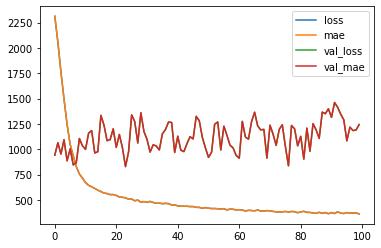

1/1 [==============================] - 0s 209ms/step - loss: 668.2272 - mae: 668.2272
[668.2272338867188, 668.2272338867188]
1/1 [==============================] - 0s 167ms/step
receta 0 kcal_true: 324.0 kcal_pred: 555.8323  precisión: 58.3 %
receta 0 carbohydrate_true: 76.0 carbohydrate_pred: 63.188408  precisión: 83.1 %
receta 0 protein_true: 8.0 protein_pred: 26.575897  precisión: 30.1 %
receta 0 total_fat_true: 0.0 total_fat_pred: 19.734917  precisión: 0.0 %
---------------------------------------------------------------------------
receta 1 kcal_true: 436.0 kcal_pred: 473.4842  precisión: 92.1 %
receta 1 carbohydrate_true: 96.0 carbohydrate_pred: 54.479927  precisión: 56.7 %
receta 1 protein_true: 8.0 protein_pred: 23.24263  precisión: 34.4 %
receta 1 total_fat_true: 4.0 total_fat_pred: 16.713398  precisión: 23.9 %
---------------------------------------------------------------------------
receta 2 kcal_true: 846.0 kcal_pred: 15249.983  precisión: 5.5 %
receta 2 carbohydrate_true:

100%|██████████| 5000/5000 [00:55<00:00, 90.87it/s] 


Calculando vector de características de 5000 recetas...


100%|██████████| 5000/5000 [17:41<00:00,  4.71it/s]


datasets/numpy/9_TEST_EMBED-128_DATA_X.npy cargado con éxito.
datasets/numpy/9_TEST_EMBED-128_DATA_Y.npy cargado con éxito.
datasets/numpy/7_VAL_EMBED-128_DATA_X.npy cargado con éxito.
datasets/numpy/7_VAL_EMBED-128_DATA_Y.npy cargado con éxito.
Model: "ModeloCNNNut_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CapaEntrada (InputLayer)    [(None, 98304)]           0         
                                                                 
 RESHAPING (Reshape)         (None, 128, 768)          0         
                                                                 
 batch_normalization_4 (Batc  (None, 128, 768)         3072      
 hNormalization)                                                 
                                                                 
 CONV_1 (Conv1D)             (None, 124, 512)          1966592   
                                                                 
 P

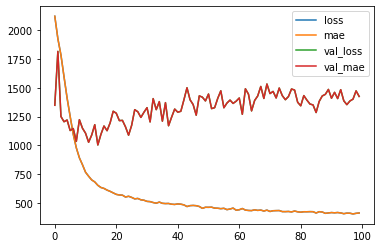

1/1 [==============================] - 0s 271ms/step - loss: 641.9249 - mae: 641.9249
[641.9249267578125, 641.9249267578125]
1/1 [==============================] - 0s 205ms/step
receta 0 kcal_true: 324.0 kcal_pred: 500.96973  precisión: 64.7 %
receta 0 carbohydrate_true: 76.0 carbohydrate_pred: 59.81683  precisión: 78.7 %
receta 0 protein_true: 8.0 protein_pred: 21.586351  precisión: 37.1 %
receta 0 total_fat_true: 0.0 total_fat_pred: 16.635046  precisión: 0.0 %
---------------------------------------------------------------------------
receta 1 kcal_true: 436.0 kcal_pred: 665.2758  precisión: 65.5 %
receta 1 carbohydrate_true: 96.0 carbohydrate_pred: 77.25847  precisión: 80.5 %
receta 1 protein_true: 8.0 protein_pred: 26.701075  precisión: 30.0 %
receta 1 total_fat_true: 4.0 total_fat_pred: 22.392488  precisión: 17.9 %
---------------------------------------------------------------------------
receta 2 kcal_true: 846.0 kcal_pred: 13703.7  precisión: 6.2 %
receta 2 carbohydrate_true: 7

In [6]:
recomendador128.NUM_RECETAS = 5000
recomendador128.EMB_SIZE = 128
ITER = 2
INITIAL_EPOCH = 0
EPOCHS = 100

Rangos_kcal = [
                (350, 1500),
                (300, 1000)
                # (200, 800)          
              ]

Histories = []
for iteracion in range(ITER):
  MINU = 1 
  MAXU = 11  

  for ik in range(len(Rangos_kcal)):
    MINK, MAXK = Rangos_kcal[ik]
    print('\nITERACIÓN:', iteracion+1)
    print('min unidades:',MINU, ' max unidades:', MAXU)
    print('min kcal:', MINK, ' max kcal:', MAXK)
    print('Entrenando desde epoch', INITIAL_EPOCH)
    print('------------------------------------------\n')
    modelo128, history = recomendador128.EntrenarModelo(df_nutricionales='nutricion_mejorado.csv',
                                  #df_training='recipes_con_info_nutricional.csv',
                                  df_test='recetas_test.csv', 
                                  df_val='recetas_val.csv',
                                  learning_rate=1e-4,
                                  version=version, 
                                  initial_epoch = INITIAL_EPOCH,                             
                                  epochs=INITIAL_EPOCH + EPOCHS, 
                                  kernels=128,                                             
                                  min_ingredientes=5, max_ingredientes=11,
                                  min_unidades=MINU, max_unidades=MAXU,  
                                  min_kcal=MINK, max_kcal= MAXK,                             
                                  save=True, verbose=True)
    INITIAL_EPOCH = history.epoch[-1]

    Histories.append(history)


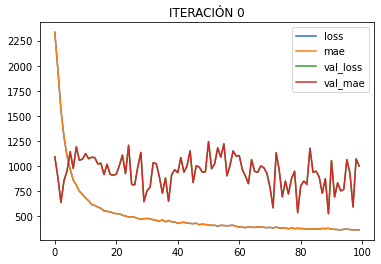

LOSS: 358.6531982421875  -- MAE: 358.6531982421875  -- VAL_LOSS: 996.2946166992188  -- VAL_MAE: 996.2946166992188
----------------------------------------------------------


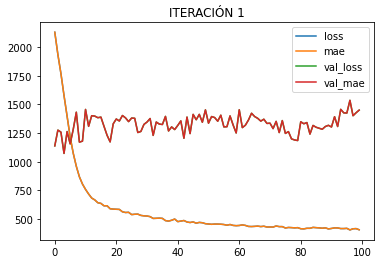

LOSS: 406.7725830078125  -- MAE: 406.7725830078125  -- VAL_LOSS: 1450.291015625  -- VAL_MAE: 1450.291015625
----------------------------------------------------------


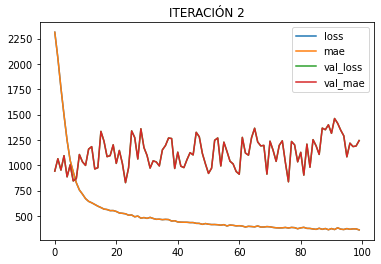

LOSS: 360.921630859375  -- MAE: 360.921630859375  -- VAL_LOSS: 1243.41455078125  -- VAL_MAE: 1243.41455078125
----------------------------------------------------------


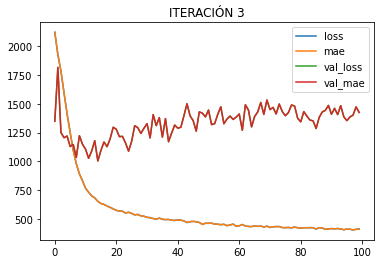

LOSS: 411.6185302734375  -- MAE: 411.6185302734375  -- VAL_LOSS: 1425.681396484375  -- VAL_MAE: 1425.681396484375
----------------------------------------------------------


In [7]:
for i in range(len(Histories)):
    history = Histories[i]    
    pd.DataFrame(history.history).plot()
    plt.title('ITERACIÓN ' + str(i))
    plt.show()
    print('LOSS:',history.history['loss'][-1], ' -- MAE:', history.history['mae'][-1], 
          ' -- VAL_LOSS:', history.history['val_loss'][-1], ' -- VAL_MAE:', history.history['val_mae'][-1])
    print('----------------------------------------------------------')

* Entrenar precios

In [9]:
recomendador128.NUM_RECETAS = 1000
recomendador128.EMB_SIZE = 128
ITER = 2
INITIAL_EPOCH = 0
EPOCHS = 20
BATCHSIZE = 32


Histories_precios = []
for iteracion in range(ITER):
    print('\nITERACIÓN:', iteracion+1)
    print('Entrenando desde epoch', INITIAL_EPOCH)
    print('------------------------------------------\n')
    modelo128_precios, history_precios = recomendador128.EntrenarModeloPrecios(
                                    df_precios='lista_precios_profeco_2022.csv',                                   
                                    learning_rate=1e-3,
                                    version=version, 
                                    initial_epoch = INITIAL_EPOCH,                             
                                    epochs=INITIAL_EPOCH + EPOCHS, 
                                    batch_size=BATCHSIZE,
                                    kernels=128,                                                                         
                                    save=True, verbose=True)
    INITIAL_EPOCH = history_precios.epoch[-1]

    Histories_precios.append(history_precios)


ITERACIÓN: 1
Entrenando desde epoch 0
------------------------------------------

Generando 1000  recetas aleatorias...



100%|██████████| 1000/1000 [00:01<00:00, 566.88it/s]


Calculando vector de características de 1000 recetas...


 85%|████████▍ | 849/1000 [03:33<00:45,  3.31it/s]

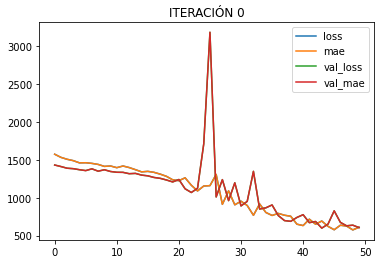

LOSS: 610.884521484375  -- MAE: 610.884521484375  -- VAL_LOSS: 605.876708984375  -- VAL_MAE: 605.876708984375
----------------------------------------------------------


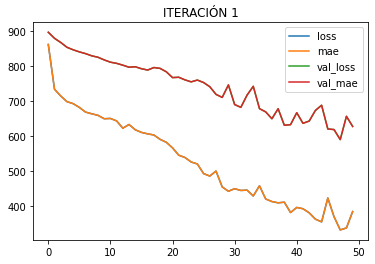

LOSS: 384.781494140625  -- MAE: 384.781494140625  -- VAL_LOSS: 627.9765014648438  -- VAL_MAE: 627.9765014648438
----------------------------------------------------------


In [10]:
for i in range(len(Histories_precios)):
    history = Histories_precios[i]    
    pd.DataFrame(history.history).plot()
    plt.title('ITERACIÓN ' + str(i))
    plt.show()
    print('LOSS:',history.history['loss'][-1], ' -- MAE:', history.history['mae'][-1], 
          ' -- VAL_LOSS:', history.history['val_loss'][-1], ' -- VAL_MAE:', history.history['val_mae'][-1])
    print('----------------------------------------------------------')